# 課題
## 何のためにデータを解析するか
離職率を高める要因が何かを特定します。
業種によって離職率が高かったり、人によって転職回数が多い場合もあります。
積極的な転職は有益ですが、不本意な転職は、働く本人にとって有益ではありませんし、雇用する企業にとって離職率が
高いことは大きな損失です。
今回は、Kaggleの、実在のロシアにおける個人離職データ
https://www.kaggle.com/datasets/davinwijaya/employee-turnover
を用いて、個人の属性が離職率を高めるのかを検証します。
そうすることで、企業が従業員の離職を減らし、従業員がより高い満足度で働くために何を改善できるのかを対策できます。

## 指標を決める（仮説を立てる）
今回は、年齢、性別、交通手段や性格診断で最も信頼性のあるとされるBig5テストの診断を用いた個人属性に関するデータを用いて、
それらが離職に影響があるのかを見ます。


## データの入手
上記の通り、kaggleで入手できた離職データを用いて分析します。

## データの分析

In [1]:
#必要なモジュールのインポート
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
df = pd.read_csv("turnover.csv",encoding="ISO-8859-1")

In [3]:
df.head()

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7


In [4]:
#このうち、会社への応募経路trafficと給与の支払い方法は結果に関連ないとみなしgreywagehの項目を除いた。
df = df.drop(["traffic","greywage"],axis='columns')

In [5]:
df.head()

,stag,event,gender,age,industry,profession,coach,head_gender,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.030801,1,m,35.0,Banks,HR,no,f,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,no,m,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,no,m,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,no,m,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,yes,f,bus,3.0,4.1,8.0,7.1,3.7


event = 離職したかどうか。離職した場合1。
stag = 経験
gender = 性別
age = 年齢
industry = 業種
profession = 職種
coach = 研修期間中にトレーナーがいたか
way = 通勤手段
extraversion = 外向性
independ = 独立性
self control = 勤勉性
anxiety = 神経症傾向
novator = 開放性

In [6]:
df.describe()

,stag,event,age,extraversion,independ,selfcontrol,anxiety,novator
count,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000
mean,36.627526,0.505757,31.066965,5.592383,5.478034,5.597254,5.665633,5.879628
std,34.096597,0.500188,6.996147,1.851637,1.703312,1.980101,1.709176,1.904016
min,0.394251,0.000000,18.000000,1.000000,1.000000,1.000000,1.700000,1.000000
25%,11.728953,0.000000,26.000000,4.600000,4.100000,4.100000,4.800000,4.400000
50%,24.344969,1.000000,30.000000,5.400000,5.500000,5.700000,5.600000,6.000000
75%,51.318275,1.000000,36.000000,7.000000,6.900000,7.200000,7.100000,7.500000
max,179.449692,1.000000,58.000000,10.000000,10.000000,10.000000,10.000000,10.000000


**項目「経験」の分散は大きそう。のちほどグラフで可視化する。**

In [7]:
df.shape
#1129名分の14項目のデータ

(1129, 14)

In [8]:
df.dtypes

stag            float64
event             int64
gender           object
age             float64
industry         object
profession       object
coach            object
head_gender      object
way              object
extraversion    float64
independ        float64
selfcontrol     float64
anxiety         float64
novator         float64
dtype: object

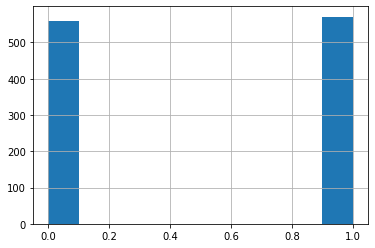

In [9]:
df["event"].hist()
#離職したか、していないかだけなので、正規分布していない。
#値は0か1しかとらない。

**予測値が0から1の範囲外にならないように、ロジスティック回帰が妥当。**

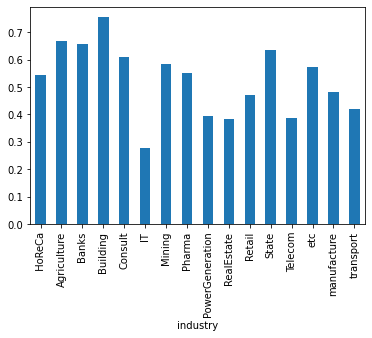

In [10]:
df_group_industry = df.groupby("industry")["event"].mean()
df_group_industry.plot.bar(by = "industry")
#IT、通信、不動産業は離職率が比較的低い一方で建設業や農業、金融、公的サービスの離職率は比較的高い。

**働く業界によって離職率が異なるとの仮説ができる。**

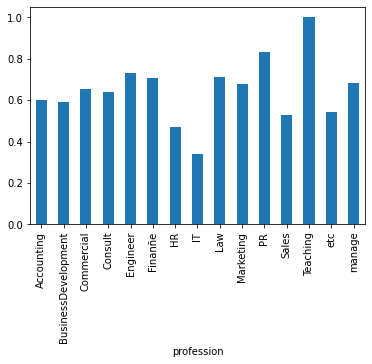

In [11]:
df_group_profession = df.groupby("profession")["event"].mean()
df_group_profession.plot.bar(by = "profession")
#教師や広告関係の職種の離職率は比較的高い。

**働く職種によって離職率が異なるとの仮説ができる。**

In [12]:
df["way"].value_counts()

bus     681
car     331
foot    117
Name: way, dtype: int64

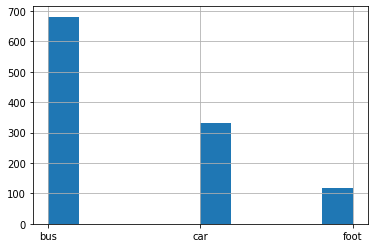

In [13]:
df["way"].hist()

**徒歩の場合は通勤時間が短いと考えられる。**

/tmp/ipykernel_23622/964150133.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df[["stag","age","gender","coach","head_gender","extraversion","independ","selfcontrol","anxiety","novator"]].hist(ax = ax)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa526315b50>,
      dtype=object)

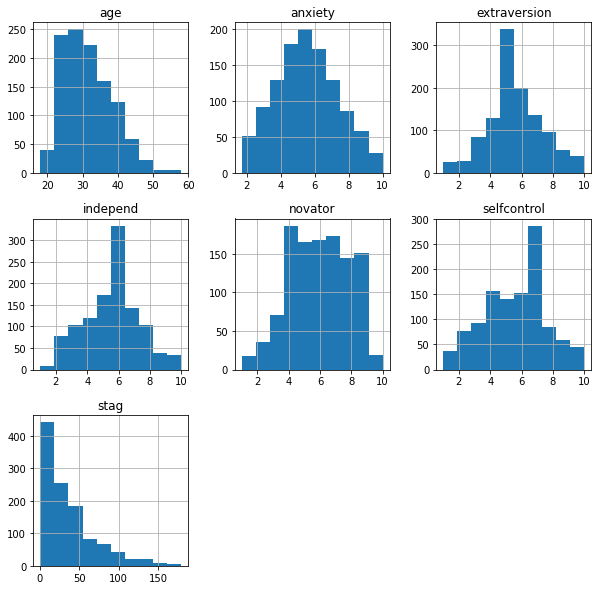

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
df[["stag","age","gender","coach","head_gender","extraversion","independ","selfcontrol","anxiety","novator"]].hist(ax = ax)

**「年齢age」と「経験stag」は偏った分布となっている。正規分布させると、標準化できるため、「年齢」と「経験」の項目を対数変換してみる。その後正規分布検定を見て、問題なければそのあと標準化する。**

In [15]:
#年齢と経験の列を対数変換する。
df['age_log'] = np.log1p(df['age'])
df['stag_log'] = np.log1p(df['stag'])

/tmp/ipykernel_23622/632451312.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df[["stag_log","age_log","gender","coach","head_gender","extraversion","independ","selfcontrol","anxiety","novator"]].hist(ax = ax)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa526b2e160>,
      dtype=object)

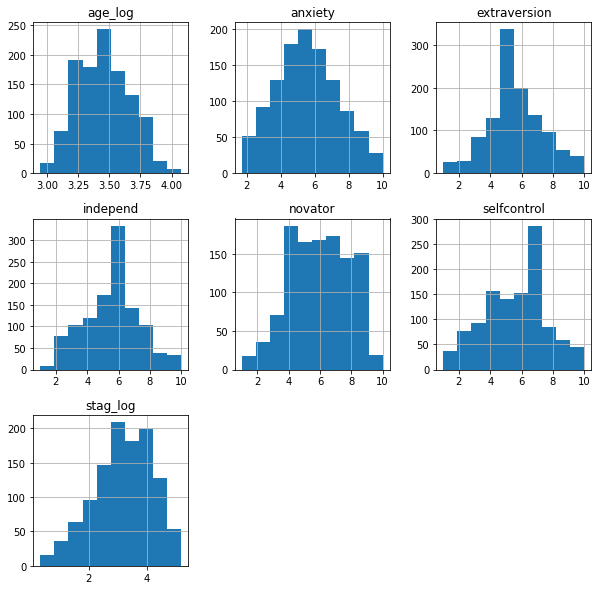

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
df[["stag_log","age_log","gender","coach","head_gender","extraversion","independ","selfcontrol","anxiety","novator"]].hist(ax = ax)

**データが正規分布しているか正規化検定を行う。**

In [17]:
W,p = stats.shapiro(df["selfcontrol"])
print(f"P値: {p:.5f}")

P値: 0.00000


シャピロ・ウィルク検定では、母集団は正規分布であるという帰無仮説が棄却された。

In [18]:
stats.kstest(df["age_log"], "norm")
print(f"P値: {p:.5f}")

P値: 0.00000


コルモゴロフ・スミルノフ検定でも、母集団は正規分布であるという帰無仮説が棄却された。
「経験」と「年齢」は母集団が正規分布していないため、これらの説明変数の標準化はしない。

In [19]:
df = df.drop(columns = ["age_log", "stag_log"])

**対数変換したデータを削除しておく**

## データの下処理

**欠損値の確認 :
欠損値はなし**

In [20]:
df.isnull().sum()
#欠損値なし

stag            0
event           0
gender          0
age             0
industry        0
profession      0
coach           0
head_gender     0
way             0
extraversion    0
independ        0
selfcontrol     0
anxiety         0
novator         0
dtype: int64

**カテゴリカル変数への変換 :     
df.dtypesでobject型だった列名"gender","age","industry","profession","coach","head_gender","way" をカテゴリカル変数に変換する。**
  

In [21]:
df_with_dummy = pd.get_dummies(data = df)
df_with_dummy.head()

,stag,event,age,extraversion,independ,selfcontrol,anxiety,novator,gender_f,gender_m,...,profession_etc,profession_manage,coach_my head,coach_no,coach_yes,head_gender_f,head_gender_m,way_bus,way_car,way_foot
0,7.030801,1,35.0,6.2,4.1,5.7,7.1,8.3,0,1,...,0,0,0,1,0,1,0,1,0,0
1,22.965092,1,33.0,6.2,4.1,5.7,7.1,8.3,0,1,...,0,0,0,1,0,0,1,1,0,0
2,15.934292,1,35.0,6.2,6.2,2.6,4.8,8.3,1,0,...,0,0,0,1,0,0,1,1,0,0
3,15.934292,1,35.0,5.4,7.6,4.9,2.5,6.7,1,0,...,0,0,0,1,0,0,1,1,0,0
4,8.410678,1,32.0,3.0,4.1,8.0,7.1,3.7,0,1,...,0,0,0,0,1,1,0,1,0,0


In [22]:
#文字化けしている列を直す
df_with_dummy["coach_head"] = df_with_dummy["coach_my head"]
df_with_dummy["industry_HoReCa"] = df_with_dummy["industry_ HoReCa"]
df_with_dummy["profession_Finance"] = df_with_dummy["profession_Finanñe"]
df_with_dummy["profession_Sales_revised"] = df_with_dummy["profession_Sales"]
df_with_dummy_revised = df_with_dummy.drop(columns = ["coach_my head","industry_ HoReCa","profession_Finanñe","profession_Sales"])

**相関行列で相関を確認する**

In [23]:
corr_matrix = df_with_dummy_revised.corr().abs()
corr_matrix.head()

,stag,event,age,extraversion,independ,selfcontrol,anxiety,novator,gender_f,gender_m,...,coach_yes,head_gender_f,head_gender_m,way_bus,way_car,way_foot,coach_head,industry_HoReCa,profession_Finance,profession_Sales_revised
stag,1.000000,0.048361,0.197381,0.088227,0.000550,0.077076,0.014755,0.037633,0.042269,0.042269,...,0.000513,0.006827,0.006827,0.099126,0.102824,0.005540,0.019235,0.005838,0.083865,0.004171
event,0.048361,1.000000,0.048751,0.015458,0.051864,0.040040,0.063232,0.006825,0.018917,0.018917,...,0.045431,0.041259,0.041259,0.034688,0.025663,0.094012,0.054593,0.007876,0.049492,0.012233
age,0.197381,0.048751,1.000000,0.149753,0.056129,0.038996,0.057782,0.039509,0.055559,0.055559,...,0.180709,0.197833,0.197833,0.097706,0.119875,0.022206,0.193528,0.024840,0.027314,0.046656
extraversion,0.088227,0.015458,0.149753,1.000000,0.200052,0.538039,0.135046,0.297375,0.146428,0.146428,...,0.087881,0.006274,0.006274,0.036401,0.045123,0.008964,0.024129,0.064878,0.017800,0.037335
independ,0.000550,0.051864,0.056129,0.200052,1.000000,0.165795,0.427209,0.023865,0.124849,0.124849,...,0.032542,0.045154,0.045154,0.038238,0.047461,0.009508,0.031578,0.050536,0.032153,0.016964


In [24]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,stag,event,age,extraversion,independ,selfcontrol,anxiety,novator,gender_f,gender_m,...,coach_yes,head_gender_f,head_gender_m,way_bus,way_car,way_foot,coach_head,industry_HoReCa,profession_Finance,profession_Sales_revised
stag,NaN,0.048361,0.197381,0.088227,0.000550,0.077076,0.014755,0.037633,0.042269,0.042269,...,0.000513,0.006827,0.006827,0.099126,0.102824,0.005540,0.019235,0.005838,0.083865,0.004171
event,NaN,NaN,0.048751,0.015458,0.051864,0.040040,0.063232,0.006825,0.018917,0.018917,...,0.045431,0.041259,0.041259,0.034688,0.025663,0.094012,0.054593,0.007876,0.049492,0.012233
age,NaN,NaN,NaN,0.149753,0.056129,0.038996,0.057782,0.039509,0.055559,0.055559,...,0.180709,0.197833,0.197833,0.097706,0.119875,0.022206,0.193528,0.024840,0.027314,0.046656
extraversion,NaN,NaN,NaN,NaN,0.200052,0.538039,0.135046,0.297375,0.146428,0.146428,...,0.087881,0.006274,0.006274,0.036401,0.045123,0.008964,0.024129,0.064878,0.017800,0.037335
independ,NaN,NaN,NaN,NaN,NaN,0.165795,0.427209,0.023865,0.124849,0.124849,...,0.032542,0.045154,0.045154,0.038238,0.047461,0.009508,0.031578,0.050536,0.032153,0.016964


**相関係数が0.8以上のものを削除する**

In [25]:
threshold = 0.8
to_drop = [column for column in upper.columns if column != 'Tip' if any(upper[column] > threshold)]

print('削除する変数：', to_drop)
print('削除する変数の数：', len(to_drop))

削除する変数： ['gender_m', 'head_gender_m']
削除する変数の数： 2


**gender、head_genderが相関係数0.8以上の項目を含む。これらは、男性と女性で完全に相関しているためgener_mとheaf_gender_mを削除する。**

In [18]:
df_with_dummy_trimmed = df_with_dummy_revised.drop(columns = to_drop)
df_with_dummy_trimmed

NameError: name 'df_with_dummy_revised' is not defined

In [17]:
df_with_dummy_trimmed_final = df_with_dummy_trimmed.drop(columns = ["profession_HR","industry_transport","way_bus","coach_no"])

NameError: name 'df_with_dummy_trimmed' is not defined

**上記は、ダミー変数のすべてのカテゴリーを列にすると、分析がうまくいかないため、業種、職種、交通手段、トレーナーがいたか、の項目のそれぞれで一つのカテゴリーを削除した**

## 回帰分析の実践

**ロジスティック回帰分析を行う**

In [16]:
model = smf.glm(formula = "event ~ stag + age + extraversion + independ + selfcontrol + anxiety + novator + gender_f + industry_Agriculture + industry_Banks + industry_Building + industry_Consult + industry_IT + industry_Mining + industry_Pharma + industry_PowerGeneration + industry_RealEstate + industry_Retail + industry_State + industry_Telecom + industry_etc + industry_manufacture + profession_Accounting + profession_BusinessDevelopment + profession_Commercial + profession_Consult + profession_Engineer + profession_IT + profession_Law + profession_Marketing + profession_PR + profession_Teaching + profession_etc + profession_manage + coach_yes + head_gender_f + way_car + way_foot + coach_head + industry_HoReCa + profession_Finance + profession_Sales_revised", data = df_with_dummy_trimmed_final, family = sm.families.Binomial()).fit()

NameError: name 'df_with_dummy_trimmed_final' is not defined

In [15]:
model.summary()

NameError: name 'model' is not defined

In [14]:
model.aic

NameError: name 'model' is not defined

**業種のカテゴリーをなくして分析してみる**

In [ ]:
model_without_industry = smf.glm(formula = "event ~ stag + age + extraversion + independ + selfcontrol + anxiety + novator + gender_f + profession_Accounting + profession_BusinessDevelopment + profession_Commercial + profession_Consult + profession_Engineer + profession_IT + profession_Law + profession_Marketing + profession_PR + profession_Teaching + profession_etc + profession_manage + coach_yes + head_gender_f + way_car + way_foot + coach_head + industry_HoReCa + profession_Finance + profession_Sales_revised", data = df_with_dummy_trimmed_final, family = sm.families.Binomial()).fit()

In [ ]:
model_without_industry.summary()

In [ ]:
model_without_industry.aic

**職種のカテゴリーをなくして分析してみる**

In [ ]:
model_without_profession = smf.glm(formula = "event ~ stag + age + extraversion + independ + selfcontrol + anxiety + novator + gender_f + industry_Agriculture + industry_Banks + industry_Building + industry_Consult + industry_IT + industry_Mining + industry_Pharma + industry_PowerGeneration + industry_RealEstate + industry_Retail + industry_State + industry_Telecom + industry_etc + industry_manufacture + industry_HoReCa", data = df_with_dummy_trimmed_final, family = sm.families.Binomial()).fit()

In [ ]:
model_without_profession.aic

## モデルの評価

In [ ]:
print(f"全ての説明変数を入れたモデル: AIC {model.aic}")
print(f"業種を説明変数から除いたモデル: AIC {model_without_industry.aic}")
print(f"職種を説明変数から除いたモデル: AIC {model_without_profession.aic}")

三つのAICを比較すると、職種と業種のカテゴリー変数を入れた回帰モデルのAICが最小であった。

# 結果の考察

## 詳細
回帰分析の結果のうち、離職率にP値5％の基準で有意に影響があったのは
「経験」、「年齢」、「徒歩通勤」、「業種：金融」、「業種：銀行」、「業種：建設」、「業種：コンサルティング」、「職種：経営層」
であった。

「経験」と「年齢」が上がるほど離職率は低下した。
職場への慣れ、業務の効率化、社会的スキルの向上などが関連していると考察できる。
「徒歩通勤」であれば、離職率は低下した。
通勤時間が長いと負担になり離職率が上がるという証拠である。
「業種：金融」、「業種：銀行」、「業種：建設」、「業種：コンサルティング」、「職種：経営層」いくつかの業種や職種では離職率が高かった。


興味深いことに、ビッグ5テストで算出された個人の気質を表す指標は、離職率に、統計的有意性の観点では影響がなかった。

## まとめ

今回は、経験、年齢、徒歩通勤、いくつかの業種と職種が離職率に影響が出ることが判明した。

職種や業種に関しては、容易に変えることが難しいかもしれない。
しかし、求職者は、通勤時間が短い企業を選ぶ、もしくは勤務先近くに居住することで、将来やめてしまうかもしれない可能性を下げることができる。
採用企業側にとっては、付近に居住しているかを指標の一つとして考慮したり、もしくはテレワークを推奨したり、中途採用に力を入れたりすることで、離職率を下げることができる。






